In [89]:
import numpy as np
import math
import cvxpy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cubic_spline_planner
import importlib
import MPC 
importlib.reload(MPC)
from MPC import *
from tqdm.notebook import tqdm

In [90]:
x1 = np.linspace(5, 43, 10)
x2 = np.repeat(42.5, 6) + np.random.normal(0, 0.75, 6)
x2 = np.clip(x2, 41, 44)

y1 = np.repeat(3, 10) + np.random.normal(0, 0.75, 10)
y1 = np.clip(y1, 2, 4)

y2 = np.linspace(7.5, 17.5, 6)

x_point = np.r_[1, x1, 41, x2, 42.5]
y_point  = np.r_[3, y1, 6, y2, 20]

In [91]:
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(x_point, y_point, ds=0.1)

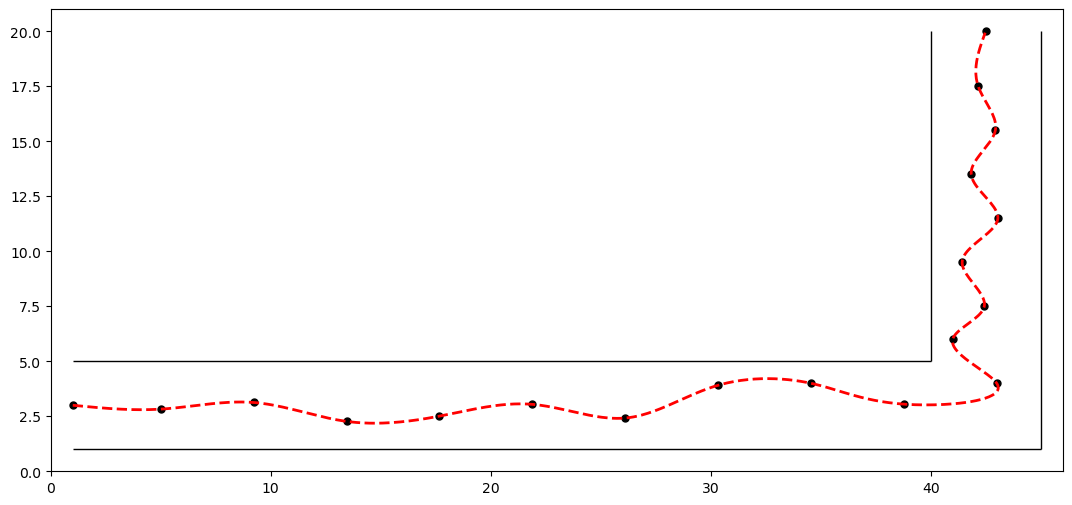

In [92]:
# Plot target points and car trajectory
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

ax.plot(x_point, y_point, 'k.', markersize=10)
ax.plot(cx, cy, 'r--', linewidth=2)

ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

ax.set_xlim(0, 46)
ax.set_ylim(0, 21)
ax.set_aspect('equal')


plt.show()

In [106]:
initial_state = Vehicle(x=cx[0], y=cy[0], yaw=cyaw[0], v=2.0)
tmp = np.array(cyaw)
tmp = np.concatenate([tmp[int(len(tmp)*0.025):], np.linspace(tmp[-1], np.pi, int(len(tmp)*0.025))])

dl = 1.0
simulation = Simulation(initial_state, goal_speed=0.5, target_speed=5)
sp = np.array(simulation.calc_speed_profile(cx, cy, cyaw))

sp[:-1] *= ((2*np.pi - np.abs(tmp)) / 2*np.pi)[:-1] / 12

In [109]:
states, controls = simulation.simulate(cx, cy, cyaw, ck, dl, sp=sp)

t = states['t']
x, y, v, yaw = states['x'], states['y'], states['v'], states['yaw']
a, d = controls['a'], controls['d']
target_inds, xrefs = controls['target_inds'], controls['xrefs']

MPC: 0it [00:00, ?it/s]

Goal


In [110]:
dx = np.empty_like(x)
dy = np.empty_like(y)

for i in range(len(x)):
    dx[i] = v[i] * math.cos(yaw[i]) * initial_state.dt
    dy[i] = v[i] * math.sin(yaw[i]) * initial_state.dt

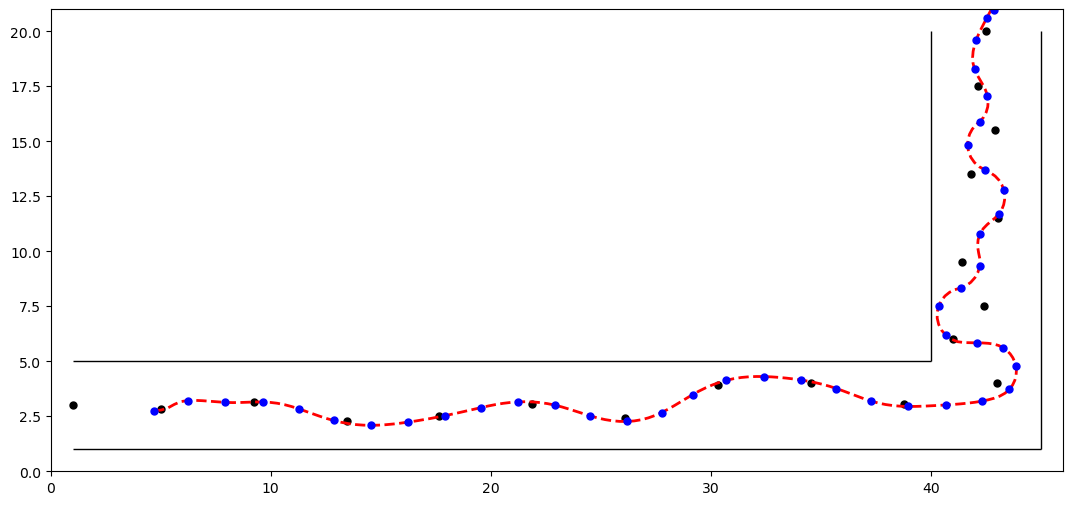

In [111]:
# Plot target points and car trajectory
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

ax.plot(x_point, y_point, 'k.', markersize=10)
ax.plot(x, y, 'r--', linewidth=2)
ax.plot(x[::5], y[::5], 'bo', linewidth=2, markersize=5)

ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

ax.set_xlim(0, 46)
ax.set_ylim(0, 21)
ax.set_aspect('equal')


plt.show()

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

def animate(i):
    ax.cla()
    ax.plot(x_point, y_point, "kx", markersize=10)
    ax.plot(x[:i], y[:i], "-b", label="trajectory")
    ax.plot(xrefs[i, 0, :], xrefs[i, 1, :], "xk", label="xref")
    ax.plot(cx[target_inds[i]], cy[target_inds[i]], "xg", label="target")
    plot_car(ax, x[i], y[i], yaw[i], steer=d[i], truckcolor="k")

    ax.set_title("Time[s]:" + str(round(t[i], 2)) + ", speed[km/h]:" + str(round(v[i] * 3.6, 2)))
    ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
    ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
    ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
    ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)
    
    ax.grid(True)
    ax.set_xlim(0, 46)
    ax.set_ylim(0, 25)
    ax.set_aspect('equal')

ani = animation.FuncAnimation(fig, animate, frames=len(x), repeat=False)

# Save animation with progress bar
with tqdm(total=len(t)) as pbar:
    ani.save('animation.gif', writer='Pillow', fps=25, progress_callback=lambda i, n: pbar.update())

plt.close()

  0%|          | 0/268 [00:00<?, ?it/s]

MovieWriter Pillow unavailable; using Pillow instead.
